In [ ]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

In [ ]:
train_set = CIFAR10('CIFAR10', train=True, download=True)
test_set = CIFAR10('CIFAR10', train=False, download=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 14122983.17it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [ ]:
train_set.data.shape, train_set.data.dtype

((50000, 32, 32, 3), dtype('uint8'))

Label: 7, class: horse


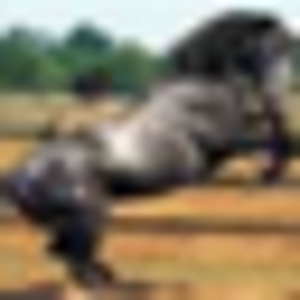

In [ ]:
image, label = train_set[113]
print(f'Label: {label}, class: {train_set.classes[label]}')
image.resize((300, 300))

In [ ]:
train_set = CIFAR10('CIFAR10', train=True, transform=T.ToTensor())
test_set = CIFAR10('CIFAR10', train=False, transform=T.ToTensor())

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def train(num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # images: batch_size x num_channels x height x width
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # (3, 32, 32)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 32, 32)
            nn.MaxPool2d(2),  # (16, 16, 16)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # (32, 16, 16)
            nn.MaxPool2d(2),  # (32, 8, 8)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 8, 8)
            nn.MaxPool2d(2),  # (64, 4, 4)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 4, 4)
            nn.ReLU()
        )

        self.classifier = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # (B, 3, 32, 32)
        feature_map = self.net(x)  # (B, 128, 4, 4)
        feature_vector = feature_map.mean(dim=(2, 3))  # (B, 128)
        logits = self.classifier(feature_vector)  # (B, 10)
        return logits

In [ ]:
x = torch.randn(16, 3, 64, 64)
model = ConvNet()

In [ ]:
model(x).shape

torch.Size([16, 10])

In [ ]:
model.net[2].weight.shape

torch.Size([32, 16, 3, 3])

In [ ]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = None

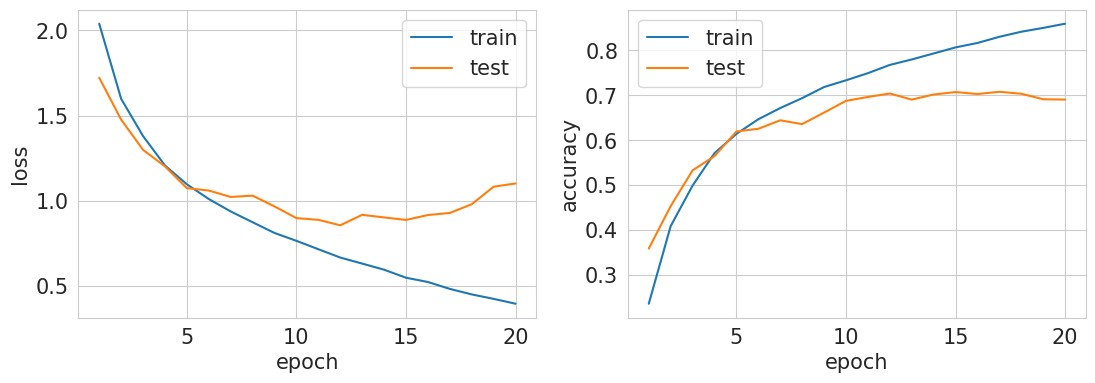

In [ ]:
train(num_epochs=20)

In [ ]:
sum(param.numel() for param in model.parameters())

98730

In [ ]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

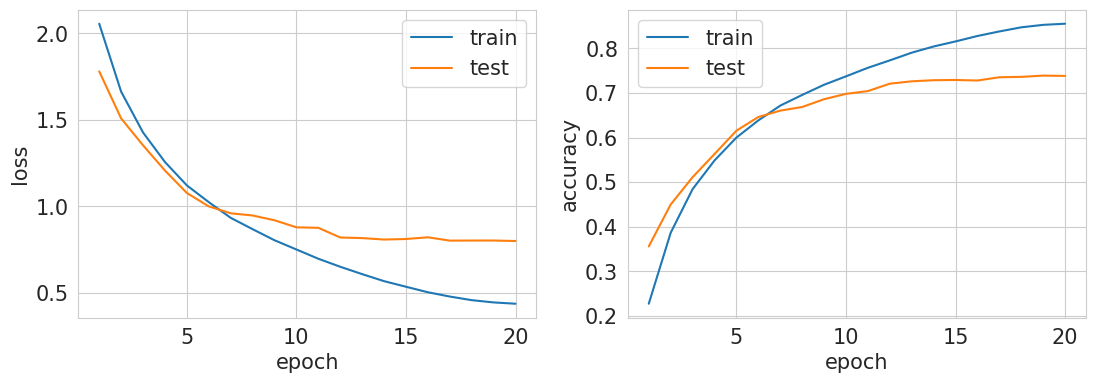

In [ ]:
train(num_epochs=20)

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_set = CIFAR10('CIFAR10', train=True, transform=train_transform)
test_set = CIFAR10('CIFAR10', train=False, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

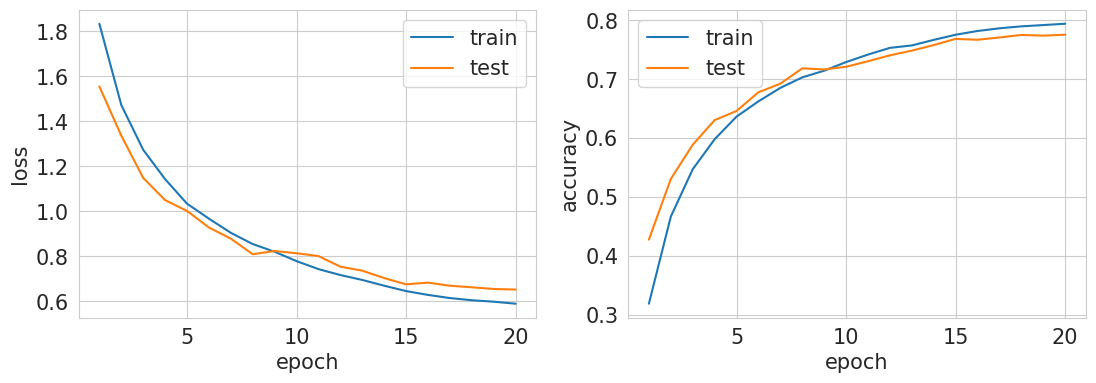

In [ ]:
train(num_epochs=20)